In [1]:
# ===============================
# Logistic Regression on Car_Insurance_Claim Dataset
# Dataset file: Car_Insurance_Claim.csv
# Target column: OUTCOME (Binary: 0/1)
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report
)

# ===============================
# Load Dataset
# Data set link : "https://www.kaggle.com/datasets/sagnik1511/car-insurance-data/data"
# ===============================
csv_path = os.path.join("Car_Insurance_Claim.csv")
df = pd.read_csv(csv_path)  # <-- use your uploaded dataset path

#print("Dataset Shape:", df.shape)
#print("Columns:", df.columns)
print(df.describe())

df.head(5)

                  ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [2]:
# ===============================
# Handle Missing Values
# ===============================

target_col = "OUTCOME"

# Check missing values
print("\nMissing values:\n", df.isnull().sum())

# BEFORE dropping missing
y_before = df[target_col]
count_before = y_before.value_counts(dropna=False)

# AFTER dropping missing rows
df_after = df.dropna()
y_after = df_after[target_col]
count_after = y_after.value_counts(dropna=False)

# align both indexes (so missing categories appear too)
summary = pd.DataFrame({
    "before_dropna": count_before,
    "after_dropna": count_after
}).fillna(0).astype(int)

# dropped count + drop %
summary["dropped_rows"] = summary["before_dropna"] - summary["after_dropna"]
summary["drop_percent"] = (summary["dropped_rows"] / summary["before_dropna"] * 100).round(2)

print(summary)


Missing values:
 ID                       0
AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64
         before_dropna  after_dropna  dropped_rows  drop_percent
OUTCOME                                                         
0.0               6867          5613          1254         18.26
1.0               3133          2536           597         19.06


In [3]:
# ===============================
# Basic Cleanup
# ===============================

# Remove duplicates if any
df_after = df_after.drop_duplicates()

# Dropping column "ID" (it is just an identifier, not useful for prediction)
if "ID" in df.columns:
    df_after.drop(columns=["ID"], inplace=True)

# Converting POSTAL_CODE as type category
df_after["POSTAL_CODE"] = df["POSTAL_CODE"].astype("category")

# Seperating features and target
X = df_after.drop(["OUTCOME"], axis=1)
y = df_after["OUTCOME"]

# Identifing numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

numeric_features, categorical_features

(['CREDIT_SCORE',
  'VEHICLE_OWNERSHIP',
  'MARRIED',
  'CHILDREN',
  'ANNUAL_MILEAGE',
  'SPEEDING_VIOLATIONS',
  'DUIS',
  'PAST_ACCIDENTS'],
 ['AGE',
  'GENDER',
  'RACE',
  'DRIVING_EXPERIENCE',
  'EDUCATION',
  'INCOME',
  'VEHICLE_YEAR',
  'POSTAL_CODE',
  'VEHICLE_TYPE'])

In [4]:
# Standard scaling the numerical features and one hot encoding the categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


#Train_Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Save test data for Streamlit
test_data = X_test.copy()
test_data["OUTCOME"] = y_test
test_data.to_csv("test_data.csv", index=False)

Logistic Regression model saved successfully!
      Metric   Value
0   Accuracy  0.8405
1        AUC  0.9151
2  Precision  0.8387
3     Recall  0.8405
4   F1 Score  0.8394
5        MCC  0.6233


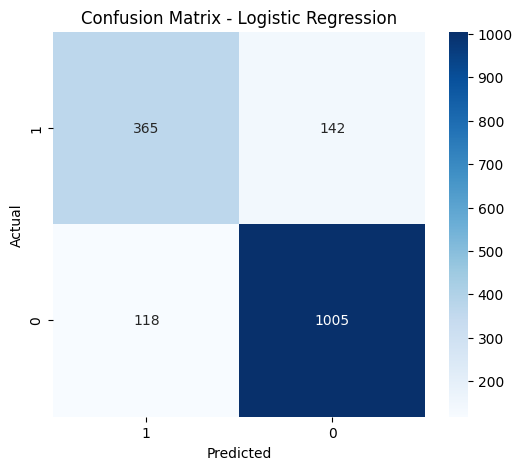

In [5]:
# ===============================
# Logistic Regression
# ===============================
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
#Training the model
logreg_pipeline.fit(X_train, y_train)

#Preciditing the output
y_log_pred = logreg_pipeline.predict(X_test)
y_log_prob = logreg_pipeline.predict_proba(X_test)[:, 1]

with open("logistic_regression.pkl", "wb") as file:
    pickle.dump(logreg_pipeline, file)

print("Logistic Regression model saved successfully!")

# ===============================
# Evalution Metrics
# ===============================
lr_accuracy = round(accuracy_score(y_test, y_log_pred), 4)
lr_auc = round(roc_auc_score(y_test, y_log_prob), 4)
lr_precision = round(precision_score(y_test, y_log_pred, average="weighted", zero_division=0), 4)
lr_recall = round(recall_score(y_test, y_log_pred, average="weighted", zero_division=0), 4)
lr_f1 = round(f1_score(y_test, y_log_pred, average="weighted", zero_division=0), 4)
lr_mcc = round(matthews_corrcoef(y_test, y_log_pred), 4)

#Print Evaluation Metrics
metrics_lr = pd.DataFrame({
    "Metric": ["Accuracy", "AUC", "Precision", "Recall", "F1 Score", "MCC"],
    "Value": [
        lr_accuracy,
        lr_auc,
        lr_precision,
        lr_recall,
        lr_f1,
        lr_mcc
    ]
})

print(metrics_lr)

# ===============================
# Confusion Matrix for Logistic Regression
# ===============================
cm = confusion_matrix(y_test, y_log_pred, labels=[1, 0])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

Decision tree model saved successfully!
      Metric   Value
0   Accuracy  0.8417
1        AUC  0.9019
2  Precision  0.8432
3     Recall  0.8417
4   F1 Score  0.8424
5        MCC  0.6340


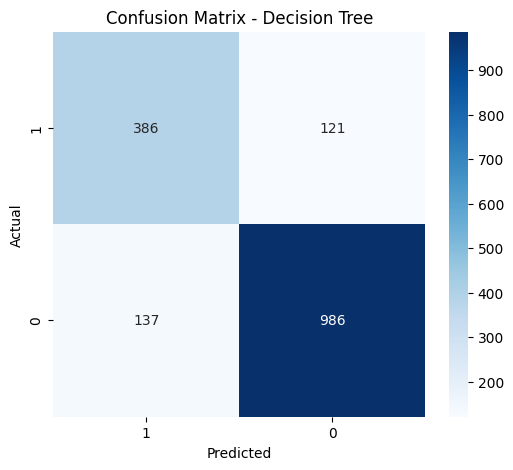

In [6]:
# ===============================
# Decision Tree
# ===============================
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        criterion='entropy',
        max_depth=6,
        random_state=42
    ))
])
#Training the model
dt_pipeline.fit(X_train, y_train)

#Preciditing the output
y_dt_pred = dt_pipeline.predict(X_test)
y_dt_prob = dt_pipeline.predict_proba(X_test)[:, 1]

with open("decision_tree.pkl", "wb") as file:
    pickle.dump(dt_pipeline, file)

print("Decision tree model saved successfully!")

# ===============================
# Evalution Metrics
# ===============================
dt_accuracy = round(accuracy_score(y_test, y_dt_pred), 4)
dt_auc = round(roc_auc_score(y_test, y_dt_prob), 4)
dt_precision = round(precision_score(y_test, y_dt_pred, average="weighted", zero_division=0), 4)
dt_recall = round(recall_score(y_test, y_dt_pred, average="weighted", zero_division=0), 4)
dt_f1 = round(f1_score(y_test, y_dt_pred, average="weighted", zero_division=0), 4)
dt_mcc = round(matthews_corrcoef(y_test, y_dt_pred), 4)

#Print Evaluation Metrics
metrics_dt = pd.DataFrame({
    "Metric": ["Accuracy", "AUC", "Precision", "Recall", "F1 Score", "MCC"],
    "Value": [
        dt_accuracy,
        dt_auc,
        dt_precision,
        dt_recall,
        dt_f1,
        dt_mcc
    ]
})

print(metrics_dt)

# ===============================
# Confusion Matrix for Decision Tree
# ===============================
cm = confusion_matrix(y_test, y_dt_pred, labels=[1, 0])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

Best parameters: {'classifier__n_neighbors': 9, 'classifier__p': 1, 'classifier__weights': 'uniform'}
KNN model saved successfully!
      Metric   Value
0   Accuracy  0.8245
1        AUC  0.8838
2  Precision  0.8223
3     Recall  0.8245
4   F1 Score  0.8231
5        MCC  0.5848


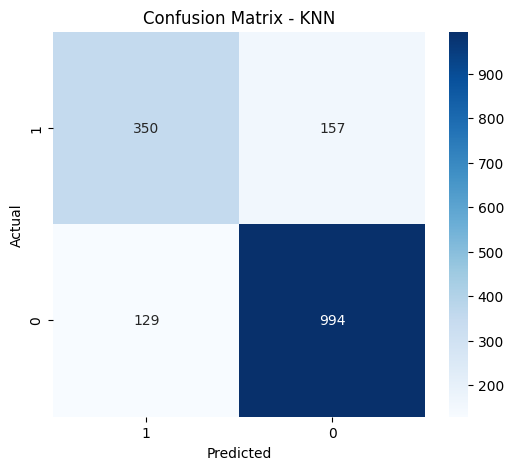

In [7]:
# ===============================
# KNN
# ===============================
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Hyperparameter grid
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]   # Manhattan (1), Euclidean (2)
}

# GridSearch
knn_grid = GridSearchCV(
    knn_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Training the model
knn_grid.fit(X_train, y_train)

# Best model from GridSearch
best_knn_model = knn_grid.best_estimator_


# Predicting the output
y_knn_pred = best_knn_model.predict(X_test)
y_knn_prob = best_knn_model.predict_proba(X_test)[:, 1]

# Save the model
with open("knn_model.pkl", "wb") as file:
    pickle.dump(best_knn_model, file)

print("Best parameters:", knn_grid.best_params_)
print("KNN model saved successfully!")

# ===============================
# Evalution Metrics
# ===============================
knn_accuracy = round(accuracy_score(y_test, y_knn_pred), 4)
knn_auc = round(roc_auc_score(y_test, y_knn_prob), 4)
knn_precision = round(precision_score(y_test, y_knn_pred, average="weighted", zero_division=0), 4)
knn_recall = round(recall_score(y_test, y_knn_pred, average="weighted", zero_division=0), 4)
knn_f1 = round(f1_score(y_test, y_knn_pred, average="weighted", zero_division=0), 4)
knn_mcc = round(matthews_corrcoef(y_test, y_knn_pred), 4)

#Print Evaluation Metrics
metrics_knn = pd.DataFrame({
    "Metric": ["Accuracy", "AUC", "Precision", "Recall", "F1 Score", "MCC"],
    "Value": [
        knn_accuracy,
        knn_auc,
        knn_precision,
        knn_recall,
        knn_f1,
        knn_mcc
    ]
})

print(metrics_knn)

# ===============================
# Confusion Matrix for KNN
# ===============================
cm = confusion_matrix(y_test, y_knn_pred, labels=[1, 0])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - KNN")
plt.show()

Gaussian Naive Bayes model saved successfully!
      Metric   Value
0   Accuracy  0.8043
1        AUC  0.8683
2  Precision  0.7987
3     Recall  0.8043
4   F1 Score  0.7992
5        MCC  0.5263


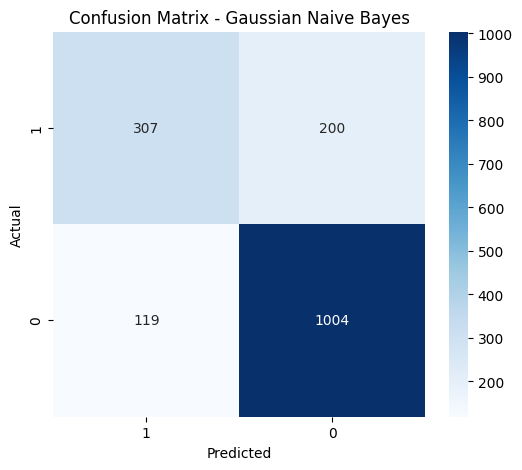

In [8]:
# ===============================
# Navie Bayes - Gaussian
# ===============================
from sklearn.naive_bayes import GaussianNB

# Gaussian Naive Bayes pipeline
gnb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# Training the model
gnb_pipeline.fit(X_train, y_train)

# Predicting the output
y_gnb_pred = gnb_pipeline.predict(X_test)
y_gnb_prob = gnb_pipeline.predict_proba(X_test)[:, 1]

# Save the model
with open("gaussian_nb_model.pkl", "wb") as file:
    pickle.dump(gnb_pipeline, file)

print("Gaussian Naive Bayes model saved successfully!")

# ===============================
# Evalution Metrics
# ===============================
gnb_accuracy = round(accuracy_score(y_test, y_gnb_pred), 4)
gnb_auc = round(roc_auc_score(y_test, y_gnb_prob), 4)
gnb_precision = round(precision_score(y_test, y_gnb_pred, average="weighted", zero_division=0), 4)
gnb_recall = round(recall_score(y_test, y_gnb_pred, average="weighted", zero_division=0), 4)
gnb_f1 = round(f1_score(y_test, y_gnb_pred, average="weighted", zero_division=0), 4)
gnb_mcc = round(matthews_corrcoef(y_test, y_gnb_pred), 4)

#Print Evaluation Metrics
metrics_gnb = pd.DataFrame({
    "Metric": ["Accuracy", "AUC", "Precision", "Recall", "F1 Score", "MCC"],
    "Value": [
        gnb_accuracy,
        gnb_auc,
        gnb_precision,
        gnb_recall,
        gnb_f1,
        gnb_mcc
    ]
})

print(metrics_gnb)

# ===============================
# Confusion Matrix for Gaussian Naive Bayes
# ===============================
cm = confusion_matrix(y_test, y_gnb_pred, labels=[1, 0])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()

Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best CV ROC-AUC: 0.9193215687262484
Random Forest model saved successfully!
      Metric   Value
0   Accuracy  0.8399
1        AUC  0.9096
2  Precision  0.8390
3     Recall  0.8399
4   F1 Score  0.8394
5        MCC  0.6242


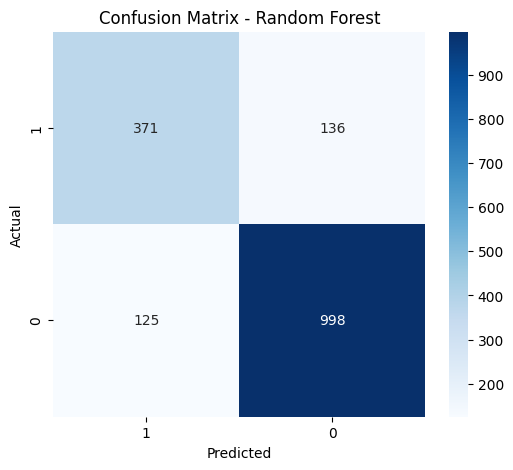

In [9]:
# ===============================
# Ensemble Model - Random Forest
# ===============================
from sklearn.ensemble import RandomForestClassifier

# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Training the model
rf_grid.fit(X_train, y_train)

# Best model from GridSearch
best_rf_model = rf_grid.best_estimator_

# Predicting the output
y_rf_pred = best_rf_model.predict(X_test)
y_rf_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Save the model
with open("random_forest_model.pkl", "wb") as file:
    pickle.dump(best_rf_model, file)

print("Best parameters:", rf_grid.best_params_)
print("Best CV ROC-AUC:", rf_grid.best_score_)
print("Random Forest model saved successfully!")

# ===============================
# Evalution Metrics
# ===============================
rf_accuracy = round(accuracy_score(y_test, y_rf_pred), 4)
rf_auc = round(roc_auc_score(y_test, y_rf_prob), 4)
rf_precision = round(precision_score(y_test, y_rf_pred, average="weighted", zero_division=0), 4)
rf_recall = round(recall_score(y_test, y_rf_pred, average="weighted", zero_division=0), 4)
rf_f1 = round(f1_score(y_test, y_rf_pred, average="weighted", zero_division=0), 4)
rf_mcc = round(matthews_corrcoef(y_test, y_rf_pred), 4)

#Print Evaluation Metrics
metrics_rf = pd.DataFrame({
    "Metric": ["Accuracy", "AUC", "Precision", "Recall", "F1 Score", "MCC"],
    "Value": [
        rf_accuracy,
        rf_auc,
        rf_precision,
        rf_recall,
        rf_f1,
        rf_mcc
    ]
})

print(metrics_rf)

# ===============================
# Confusion Matrix for Random Forest
# ===============================
cm = confusion_matrix(y_test, y_rf_pred, labels=[1, 0])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best CV ROC-AUC: 0.9246176722800381
XGBoost model with GridSearch saved successfully!
      Metric   Value
0   Accuracy  0.8423
1        AUC  0.9156
2  Precision  0.8416
3     Recall  0.8423
4   F1 Score  0.8419
5        MCC  0.6304


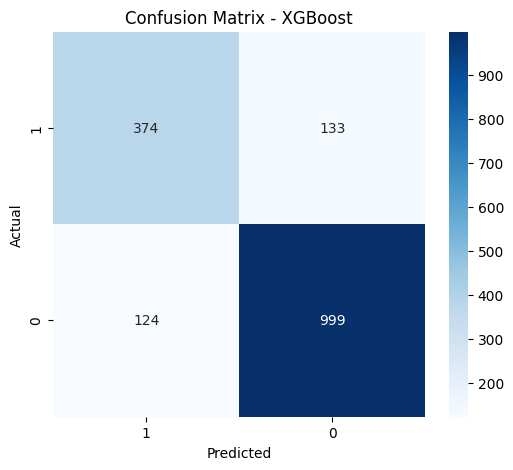

In [10]:
# ===============================
# Ensemble Model - XGBoost
# ===============================
from xgboost import XGBClassifier

# XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

# Hyperparameter grid
param_grid = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [4, 6],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# GridSearchCV
xgb_grid = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Training the model
xgb_grid.fit(X_train, y_train)

# Best model from GridSearch
best_xgb_model = xgb_grid.best_estimator_

# Predicting the output
y_xgb_pred = best_xgb_model.predict(X_test)
y_xgb_prob = best_xgb_model.predict_proba(X_test)[:, 1]

# Save the best model
with open("xgboost_best_model.pkl", "wb") as file:
    pickle.dump(best_xgb_model, file)
    
print("Best parameters:", xgb_grid.best_params_)
print("Best CV ROC-AUC:", xgb_grid.best_score_)
print("XGBoost model with GridSearch saved successfully!")

# ===============================
# Evalution Metrics
# ===============================
xgb_accuracy = round(accuracy_score(y_test, y_xgb_pred), 4)
xgb_auc = round(roc_auc_score(y_test, y_xgb_prob), 4)
xgb_precision = round(precision_score(y_test, y_xgb_pred, average="weighted", zero_division=0), 4)
xgb_recall = round(recall_score(y_test, y_xgb_pred, average="weighted", zero_division=0), 4)
xgb_f1 = round(f1_score(y_test, y_xgb_pred, average="weighted", zero_division=0), 4)
xgb_mcc = round(matthews_corrcoef(y_test, y_xgb_pred), 4)

#Print Evaluation Metrics
metrics_xgb = pd.DataFrame({
    "Metric": ["Accuracy", "AUC", "Precision", "Recall", "F1 Score", "MCC"],
    "Value": [
        xgb_accuracy,
        xgb_auc,
        xgb_precision,
        xgb_recall,
        xgb_f1,
        xgb_mcc
    ]
})

#Display
print(metrics_xgb)

# ===============================
# Confusion Matrix for XGBoost
# ===============================
cm = confusion_matrix(y_test, y_xgb_pred, labels=[1, 0])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [13]:
readme_content = f"""
# Car Insurance Claim Prediction

## a. Problem Statement
Insurance companies need to accurately predict whether a customer is likely to file an insurance claim. Incorrect predictions can lead to financial losses or missed risk mitigation opportunities.
The objective of this project is to predict whether a customer will file an insurance claim based on demographic, driving, and vehicle-related features.
This is a binary classification problem where:
- 0 = No claim
- 1 = Claim

## b. Dataset Description
The dataset contains customer and vehicle information related to car insurance policies. Each row represents a single policyholder.

Target Variable:
OUTCOME
0 → No insurance claim
1 → Insurance claim

Key Features:
Demographic details: AGE, GENDER, RACE, EDUCATION, INCOME, MARRIED, CHILDREN
Driving behavior: DRIVING_EXPERIENCE, SPEEDING_VIOLATIONS, DUIS, PAST_ACCIDENTS
Vehicle information: VEHICLE_TYPE, VEHICLE_YEAR, VEHICLE_OWNERSHIP, ANNUAL_MILEAGE
Financial indicator: CREDIT_SCORE

Categorical features were encoded and numerical features were scaled using a preprocessing pipeline.

## c. Models Used
1. Logistic Regression
2. Decision Tree
3. k-Nearest Neighbors (kNN)
4. Naive Bayes (Gaussian)
5. Random Forest (Ensemble)
6. XGBoost (Ensemble)

## Model Comparison Table

┌──────────────────────┬──────────┬────────┬───────────┬────────┬───────┬───────┐
│ ML Model Name        │ Accuracy │  AUC   │ Precision │ Recall │  F1   │  MCC  │
├──────────────────────┼──────────┼────────┼───────────┼────────┼───────┼───────┤
│ Logistic Regression  │  {lr_accuracy:.3f}   │ {lr_auc:.3f}  │   {lr_precision:.3f}   │ {lr_recall:.3f}  │ {lr_f1:.3f} │ {lr_mcc:.3f} │
|----------------------|----------|--------|-----------|--------|-------|-------|
│ Decision Tree        │  {dt_accuracy:.3f}   │ {dt_auc:.3f}  │   {dt_precision:.3f}   │ {dt_recall:.3f}  │ {dt_f1:.3f} │ {dt_mcc:.3f} │
|----------------------|----------|--------|-----------|--------|-------|-------|
│ kNN                  │  {knn_accuracy:.3f}   │ {knn_auc:.3f}  │   {knn_precision:.3f}   │ {knn_recall:.3f}  │ {knn_f1:.3f} │ {knn_mcc:.3f} │
|----------------------|----------|--------|-----------|--------|-------|-------|
│ Naive Bayes          │  {gnb_accuracy:.3f}   │ {gnb_auc:.3f}  │   {gnb_precision:.3f}   │ {gnb_recall:.3f}  │ {gnb_f1:.3f} │ {gnb_mcc:.3f} │
|----------------------|----------|--------|-----------|--------|-------|-------|
│ Random Forest        │  {rf_accuracy:.3f}   │ {rf_auc:.3f}  │   {rf_precision:.3f}   │ {rf_recall:.3f}  │ {rf_f1:.3f} │ {rf_mcc:.3f} │
|----------------------|----------|--------|-----------|--------|-------|-------|
│ XGBoost              │  {xgb_accuracy:.3f}   │ {xgb_auc:.3f}  │   {xgb_precision:.3f}   │ {xgb_recall:.3f}  │ {xgb_f1:.3f} │ {xgb_mcc:.3f} │
└──────────────────────┴──────────┴────────┴───────────┴────────┴───────┴───────┘


┌───────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────┐
| ML Model Name         | Observation about model performance                                                                     |
|-----------------------|---------------------------------------------------------------------------------------------------------|
| Logistic Regression   | Provides balanced and stable performance with strong AUC (0.915) and consistent precision and           |
|                       | recall (~0.84). Serves as a solid baseline model with good generalization ability.                      |
|-----------------------|---------------------------------------------------------------------------------------------------------|
| Decision Tree         | Shows competitive accuracy (0.842) and good precision, but slightly lower AUC (0.902).                  |
|                       | May suffer from overfitting compared to ensemble methods, though still performs well overall.           |
|-----------------------|---------------------------------------------------------------------------------------------------------|
| kNN                   | Moderate performance with AUC (0.884) and MCC (0.585). Performance may be affected by feature scaling   |
|                       | and sensitivity to noise, resulting in slightly reduced effectiveness compared to tree-based models     |
|-----------------------|---------------------------------------------------------------------------------------------------------|
| Naive Bayes           | Lowest overall performance among all models (Accuracy: 0.804, MCC: 0.526). Assumption of feature        |
|                       | independence likely limits predictive capability, though it remains computationally efficient & simple. |
|-----------------------|---------------------------------------------------------------------------------------------------------|
| Random Forest         | Strong performance across all metrics (Accuracy: 0.840, AUC: 0.910).                                    |
| (Ensemble)            | More robust than single Decision Tree and better at handling complex feature interactions.              |
|-----------------------|---------------------------------------------------------------------------------------------------------|
| XGBoost               | Best overall performing model with highest AUC (0.916) & strong balance across precision, recall, and   |
| (Ensemble)            | F1 score (≈0.842). Demonstrates superior generalization & ability to capture subtle patterns in dataset.|
└───────────────────────┴─────────────────────────────────────────────────────────────────────────────────────────────────────────┘

"""

with open("README.md", "w", encoding="utf-8") as file:
    file.write(readme_content)

print("README.md file created successfully!")

README.md file created successfully!
